# Trend analysis with LSTM vs GRU cells

Trend analysis. A comparison of LSTM vs GRU.

The purpose of this notebook is to perform trend prediction with models based on LSTM and GRU and compare the results.

The networks are trained on the trend of amazon provided by https://finance.yahoo.com/ on a 10 years period.

In [1]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
if not tf.config.list_physical_devices('XLA_CPU'):
    print("No GPU was detected.")

gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'XLA_GPU')


In [5]:
#uploading data for training
amazon=pd.read_csv('AMZN.csv')

In [6]:
#general variables
n_step_ahead_close=6  #n steps to predict
l=len(amazon)
fit_length=60 #n data to process


## Dataset preprocessing

Preparing data:
- get "close" column
- normalize dataset
- create training, validation and test set

In [7]:
#get just the interested column
amazon_close=amazon['Close'].to_numpy().astype(np.float32)

In [8]:
#normalizing the dataset from 0 (min) to 1(max value)
norm_= MinMaxScaler(feature_range=(0,1))

#fit and then transform
amazon_close = norm_.fit_transform(amazon_close[..., np.newaxis])


In [9]:
def get_x_y(trend):
    
    x_trend=np.empty((0,fit_length))
    y_trend=np.empty((0,n_step_ahead_close))
    
    index=fit_length
    while (index+n_step_ahead_close) <l:
        x_trend=np.append(x_trend,[amazon_close[index-fit_length:index,0]],axis=0)
        y_trend=np.append(y_trend,[amazon_close[index:index+n_step_ahead_close,0]],axis=0)

        index+=1
        
    
    return x_trend,y_trend

In [10]:
X,y=get_x_y(amazon_close)
X.shape, y.shape

((2452, 60), (2452, 6))

In [11]:
#training, validation and test dimension
n_train=int((l)*0.7)
n_val=int((l)*0.2)
n_test=l-n_val-n_train

X_training=X[:n_train,:]
X_validation=X[n_train:n_train+n_val,:]
X_test=X[-n_test:]

X_training=X_training[..., np.newaxis].astype(np.float32)
X_validation=X_validation[..., np.newaxis].astype(np.float32)
X_test=X_test[..., np.newaxis].astype(np.float32)

y_training=y[:n_train]
y_validation=y[n_train:n_train+n_val]
y_test=y[-n_test:]

In [12]:
X_training.shape,y_training.shape

((1762, 60, 1), (1762, 6))

In [13]:
X_validation.shape,y_validation.shape

((503, 60, 1), (503, 6))

In [14]:
X_test.shape,y_test.shape

((253, 60, 1), (253, 6))

## Building the networks

### Network to predict N steps ahead of the 'close' value

In [15]:
from tensorflow.keras.layers import GRU, Dense, Dropout,LSTM,LayerNormalization

from tensorflow.keras.metrics import mean_squared_error as mse


In [16]:
K.clear_session()

In [17]:
#defining the model for LSTM

model_LSTM =keras.models.Sequential([
    LSTM(120, return_sequences=True,input_shape=[None,1]),
    #LayerNormalization(),
    Dropout(0.1),
    LSTM(120, return_sequences=False),
    #Dropout(0.1),
    Dense(n_step_ahead_close)
])

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 120)         58560     
_________________________________________________________________
dropout (Dropout)            (None, None, 120)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense (Dense)                (None, 6)                 726       
Total params: 174,966
Trainable params: 174,966
Non-trainable params: 0
_________________________________________________________________


In [18]:
#define mse just in the last steps

@tf.function
def last_step_mse(y_gt,y_p):
    return mse(y_gt,y_p)

In [19]:
model_LSTM.compile(loss=mse, optimizer='adam', metrics=[last_step_mse])

In [20]:
early_stopping_= tf.keras.callbacks.EarlyStopping(patience=2)

In [21]:
hystory_LSTM=model_LSTM.fit(X_training,y_training,epochs=10, 
                       validation_data=(X_validation,y_validation),
                       callbacks=[early_stopping_],
                       batch_size=32,
                       shuffle=True)

Epoch 1/10
56/56 [==============================] - 3s 49ms/step - loss: 0.0017 - last_step_mse: 0.0017 - val_loss: 0.0014 - val_last_step_mse: 0.0014
Epoch 2/10
56/56 [==============================] - 2s 41ms/step - loss: 7.8884e-05 - last_step_mse: 7.8884e-05 - val_loss: 0.0014 - val_last_step_mse: 0.0014
Epoch 3/10
56/56 [==============================] - 2s 41ms/step - loss: 7.2852e-05 - last_step_mse: 7.2852e-05 - val_loss: 0.0011 - val_last_step_mse: 0.0011
Epoch 4/10
56/56 [==============================] - 2s 42ms/step - loss: 7.4949e-05 - last_step_mse: 7.4949e-05 - val_loss: 0.0028 - val_last_step_mse: 0.0028
Epoch 5/10
56/56 [==============================] - 2s 42ms/step - loss: 8.1306e-05 - last_step_mse: 8.1306e-05 - val_loss: 0.0015 - val_last_step_mse: 0.0015


In [22]:
model_LSTM.evaluate(X_test,y_test) #best result= 0.0018

8/8 [==============================] - 0s 12ms/step - loss: 0.0021 - last_step_mse: 0.0021  


[0.0021291417069733143, 0.0021291417069733143]

In [23]:
#defining the model for GRU
model_GRU =keras.models.Sequential([
    GRU(120, return_sequences=True,input_shape=[None,1]),
    Dropout(0.1),
    #LayerNormalization(),
    GRU(120, return_sequences=False),
    #Dropout(0.1),
    Dense(n_step_ahead_close)

    
])
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 120)         44280     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 120)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 120)               87120     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 726       
Total params: 132,126
Trainable params: 132,126
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_GRU.compile(loss=mse, optimizer='adam', metrics=[last_step_mse])
hystory_GRU=model_GRU.fit(X_training,y_training,epochs=5, 
                       validation_data=(X_validation,y_validation),
                       callbacks=[early_stopping_],
                       batch_size=32,
                       shuffle=True)


Epoch 1/5
56/56 [==============================] - 3s 46ms/step - loss: 0.0014 - last_step_mse: 0.0014 - val_loss: 5.5540e-04 - val_last_step_mse: 5.5540e-04
Epoch 2/5
56/56 [==============================] - 2s 40ms/step - loss: 6.2256e-05 - last_step_mse: 6.2256e-05 - val_loss: 5.0663e-04 - val_last_step_mse: 5.0663e-04
Epoch 3/5
56/56 [==============================] - 2s 40ms/step - loss: 5.3028e-05 - last_step_mse: 5.3028e-05 - val_loss: 5.0531e-04 - val_last_step_mse: 5.0531e-04
Epoch 4/5
56/56 [==============================] - 2s 40ms/step - loss: 5.3734e-05 - last_step_mse: 5.3734e-05 - val_loss: 7.4725e-04 - val_last_step_mse: 7.4725e-04
Epoch 5/5
56/56 [==============================] - 2s 41ms/step - loss: 5.9742e-05 - last_step_mse: 5.9742e-05 - val_loss: 5.4480e-04 - val_last_step_mse: 5.4480e-04


In [25]:
model_GRU.evaluate(X_test,y_test)  #best result= 0.0013

8/8 [==============================] - 0s 9ms/step - loss: 0.0015 - last_step_mse: 0.0015   


[0.001530003733932972, 0.001530003733932972]

In [26]:
#test of the i-th item of the test where i=
i=155

predictions_L=model_LSTM.predict(X_test[None,i,...])
predictions_G=model_GRU.predict(X_test[None,i,...])

predictions_L,predictions_G,y_test[i]

(array([[0.8824197 , 0.883357  , 0.89348084, 0.90915   , 0.8826542 ,
         0.8960096 ]], dtype=float32),
 array([[0.84435123, 0.82901263, 0.84452564, 0.8540472 , 0.8727099 ,
         0.87200356]], dtype=float32),
 array([0.85771459, 0.89118165, 0.87551922, 0.8835122 , 0.9031533 ,
        0.90907824]))

## Results

Plotting results

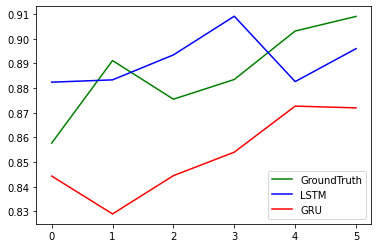

In [27]:

plt.plot(y_test[i],color='g',label="GroundTruth")
plt.plot(predictions_L[0],color='b',label="LSTM")
plt.plot(predictions_G[0],color='r',label="GRU")
plt.legend(loc='lower right')
#plt.ylim(0,1)

(0.0, 1.0)

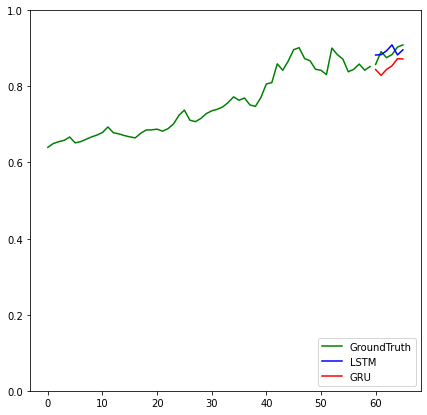

In [28]:
plt.figure(figsize=(7,7))

plt.plot(X_test[i],color='g')
plt.plot(np.arange(fit_length,fit_length+n_step_ahead_close),y_test[i],color='g',label="GroundTruth")

plt.plot(np.arange(fit_length,fit_length+n_step_ahead_close),predictions_L[0],color='b',label="LSTM")
plt.plot(np.arange(fit_length,fit_length+n_step_ahead_close),predictions_G[0],color='r',label="GRU")
plt.legend(loc='lower right')
plt.ylim(0,1)